Associated Git repository: https://github.com/kaushal0611/DL-project-final-submission.git

# Creating Distil-BERT (Task-Specific for NER) by Neural-Network Distillation on BERT 
In this notebook, we demonstrate **Neural Network Knowledge Distillatation**, which was first talked about by Hinton et al, https://arxiv.org/pdf/1503.02531.pdf. Knowledge distillation is a compression technique in which
a compact model - the student - is trained to reproduce the behaviour of a larger model - the teacher - or an ensemble of models

Today, for most NLP tasks, we have standard large-scale pre-trained models like BERT, etc. However, as mentioned in the Distilbert paper, operating these large models in on-the-edge and/or under constrained computational training or inference budgets remains challenging

We demonstrate how a Large Model for a finetuned task - Named Entity Recognition, or in general, Token classification can be used to "teach" a smaller model the same task. 
The smaller model is initialized from the larger model - however, as in the paper, we only take one layer out of two, i.e, half the number of layers in the student model

# Setup Architecture
Our setup consists of 2 models: The teacher (a larger model) and a student. 

Given input, we run the teacher and student models on the input and produce their output embeddings, as shown in the figure. The student is made to "mimic" the teacher, hence, we assume that the teacher's outputs are "correct", or at least, better. We calculate the loss, and use this loss the update the student, to make it more accurate with respect to the teacher model 

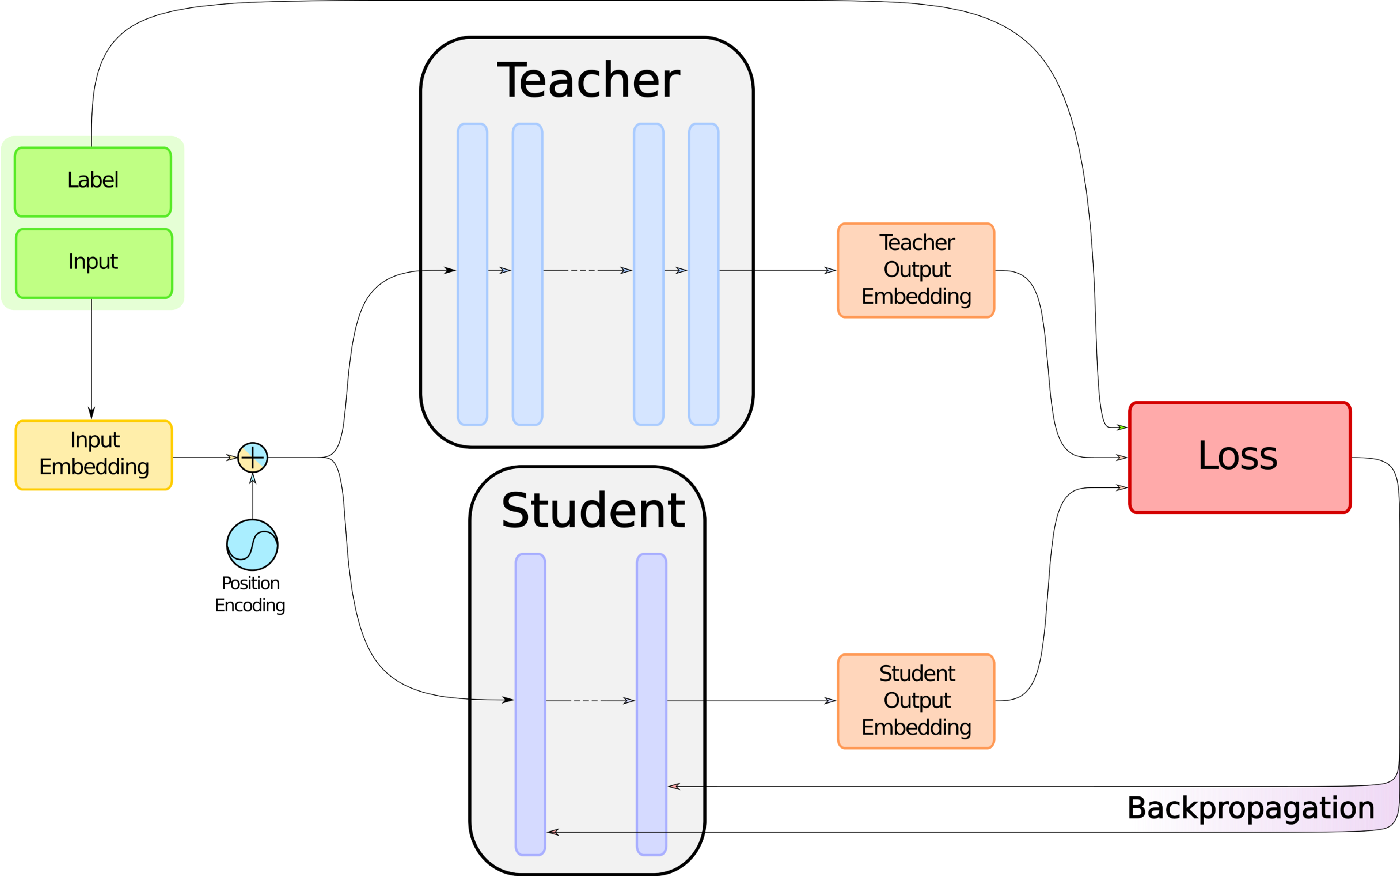

They are two different types of knowledge distillation, the Task-agnostic knowledge distillation and the Task-specific knowledge distillation. 

In this submission we are going to use the Task-specific knowledge distillation.
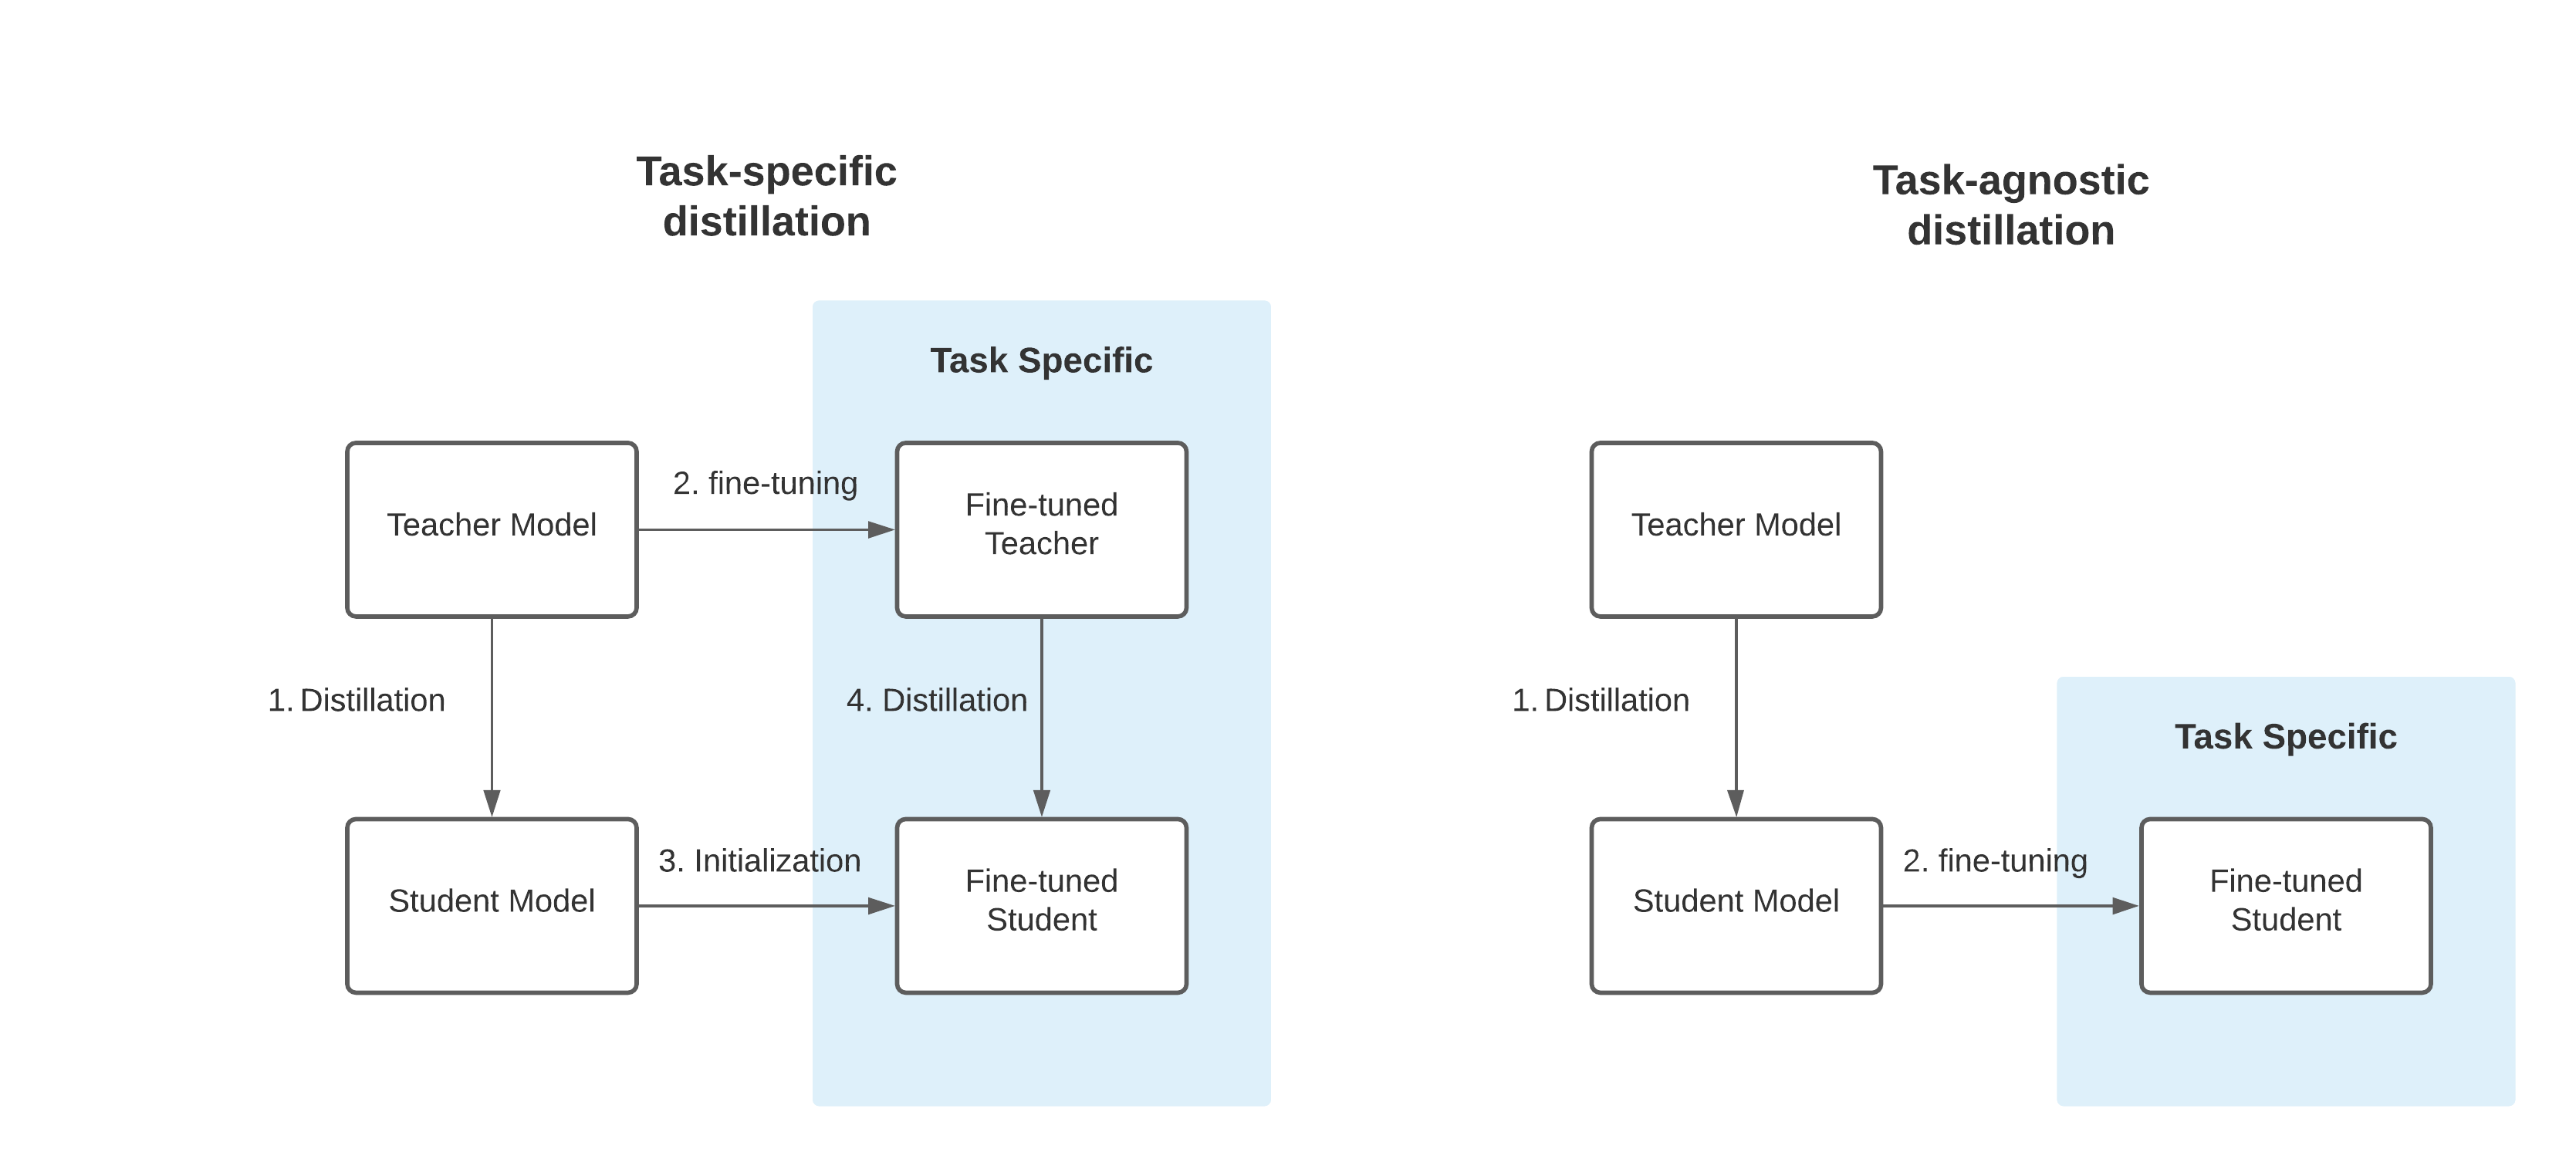

As seen in the above figure, in Task-Specific knowledge distillation, there is "task-specific" step of distillation, used to fine-tune the model on a given dataset. This idea comes from the DistilBERT paper where it was shown that a student performed better than simply finetuning the distilled language model:

"We also studied whether we could add another step of distillation during the adaptation phase by fine-tuning DistilBERT on SQuAD using a BERT model previously fine-tuned on SQuAD as a teacher for an additional term in the loss (knowledge distillation). In this setting, there are thus two successive steps of distillation, one during the pre-training phase and one during the adaptation phase. In this case, we were able to reach interesting performances given the size of the model:79.8 F1 and 70.4 EM, i.e. within 3 points of the full model."

### Install (HuggingFace) Transformers, Datasets
We will use the Huggingface transformers library which provides a single API through which any Transformer model can be loaded, trained, and saved.
We will also use the datasets library to download our dataset.

In [ ]:
%pip install transformers datasets --upgrade
!pip install seqeval

     |████████████████████████████████| 4.2 MB 9.7 MB/s 
     |████████████████████████████████| 342 kB 62.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.4 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 1.1 MB 45.9 MB/s 
     |████████████████████████████████| 136 kB 15.7 MB/s 
     |████████████████████████████████| 212 kB 49.7 MB/s 
     |████████████████████████████████| 127 kB 55.3 MB/s 
     |████████████████████████████████| 144 kB 50.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 77.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
E

### Loading the Dataset, CONLL2003

CoNLL-2003 was built for language-independent named entity recognition. It has four types of named entities: persons, locations, organizations and names of miscellaneous entities (everything not in the first three groups). 

* It contains four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. 
* The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. 
* The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. 
* Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. 
* A word with tag O is not part of a phrase.

Eg:
``` 
{
    "chunk_tags": [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 13, 11, 21, 22, 11, 12, 17, 11, 21, 17, 11, 12, 12, 21, 22, 22, 13, 11, 0],
    "id": "0",
    "ner_tags": [0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "pos_tags": [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 35, 24, 35, 37, 16, 21, 15, 24, 41, 15, 16, 21, 21, 20, 37, 40, 35, 21, 7],
    "tokens": ["The", "European", "Commission", "said", "on", "Thursday", "it", "disagreed", "with", "German", "advice", "to", "consumers", "to", "shun", "British", "lamb", "until", "scientists", "determine", "whether", "mad", "cow", "disease", "can", "be", "transmitted", "to", "sheep", "."]
}
```

Load the CoNLL-2003 dataset using load_dataset.

In [ ]:
from datasets import load_dataset
raw_datasets = load_dataset("conll2003")
from huggingface_hub import HfFolder

Generating train split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3454 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The model has been downloaded and cached, we can see more about it's elements below.

In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3251
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3454
    })
})


#### About the class labels
* O means the word doesn’t correspond to any entity.
* B-PER/I-PER means the word corresponds to the beginning of/is inside a person  entity.
* B-ORG/I-ORG means the word corresponds to the beginning of/is inside an organization entity.
* B-LOC/I-LOC means the word corresponds to the beginning of/is inside a location entity.
* B-MISC/I-MISC means the word corresponds to the beginning of/is inside a miscellaneous entity.

In [ ]:
print(raw_datasets["train"][0]["tokens"])
print(raw_datasets["train"][0]["ner_tags"])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [ ]:
ner_feature = raw_datasets["train"].features["ner_tags"]
print(ner_feature)
label_names = ner_feature.feature.names
print(label_names)

Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


### Texts → token IDs using a tokenizer
We use Transformers' Auto Tokenizer which will tokenize the inputs (including converting the tokens to their corresponding IDs in the **pretrained vocabulary**)
That's why we use AutoTokenizer by providing the model_checkpoint as shown below. It is because we want the tokenizer to be similar to what the model created was trained on. So for example, here we want a BERT-based tokenizer, with the same vocabulary that BERT was trained on

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

We add ```is_split_into_words=True``` to tokenize our pre-tokenized input.
This adds ```[CLS]``` at the beginning and ```[SEP]``` at the end for the model

In [ ]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
print(len(inputs["input_ids"]))
print(len(raw_datasets["train"][0]["ner_tags"]))
# Notice the tags now are lesser than words (or tokens), so we need to expand it

12
9


#### Expand our label list to match the tokens
* Special tokens get a label of -100, an index that is ignored in the loss function we will use (cross entropy). 
* Each token gets the same label as the token that started the word it’s inside, since they are part of the same entity. 
* For tokens inside a word but not at the beginning, we replace the B- with I- (since the token does not begin the entity

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


#### Preprocess whole dataset
* We need to tokenize all the inputs and apply align_labels_with_tokens() on all the labels.
* word_ids() function needs to get the index of the example we want the word IDs of. Here the inputs to the tokenizer are lists of lists of words.

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

#### Apply all the pre-processing steps

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

#### Add padding so that labels are padded the same way as inputs
* We use DataCollatorForTokenClassification to make sure our labels are padded the same way as the inputs.
* It takes the tokenizer used to preprocess the inputs.
* -100 is used to signifiy the corresponding predictions being ignored in the loss computation.

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
print(batch["labels"])
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

# Notice the Padding

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


#### Prepare metrics for training
First, we need ```seqeval``` to evaluate token classification prediction.
It takes the lists of labels as a string, so we need to decode the predictions and labels before passing them to the metric. 

In [ ]:
from datasets import load_metric
metric = load_metric("seqeval")

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

* The ```compute_metrics()``` function takes the argmax of the logits to convert them to predictions. 
* Then we convert both labels and predictions from integers to strings.
* We remove all the values where the label is -100, then pass the results to the metric.compute() method

In [ ]:
import numpy as np
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

## Loading the "Teacher Model". Here, it is a pretrained BERT-model, finetuned specifically for NER. 
Now, we shall download and load our teacher model, which is a Medium-Sized BERT-based model (about 430MB in size) trained specifically for Named Entity Recognition. It is called "bert-base-NER", and this is the name used to reference it on the HuggingFace models list.

We initially wanted to try to distill bert-large-NER, which is about (1.2GB in size), but when we tried to do so, we ran out of CUDA memory during training)

In [ ]:
from transformers import AutoModelForTokenClassification
# Recall: model_checkpoint = "dslim/bert-base-NER"
teacher_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Notice above the the **size of the teacher model is about 0.5GB**

### Please Note:
To run the coming cells, you will need a HuggingFace token. It is a 2-minute procedure to obtain the same:
1. Just run the cell below
2. Click on the link and sign up for a HuggingFace account
3. You will get the mail to verify the above step, after which you can generate a token. Keep the mode as "write".

IF YOU ARE FACING TROUBLE WITH THE ABOVE STEPS/NOT ABLE TO RUN, PLEASE CONTACT ANY ONE OF US, WE WILL SHARE OUR TOKEN WITH YOU

In [ ]:
# HuggingFace Login
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Creating the Custom DistillationTrainer class by making it a subclass of the Transformers Trainer class. 
In the transformers library, The Trainer class provides an API for feature-complete training in PyTorch for most standard use cases

However, we are doing something different here, the trainer would normally expect only one model. But we need to pass in 2 models: The teacher and the student

So, we create a SubClass as an inherited class of "Trainer" class, because we want to modify the "compute_loss" function and the init method. To add to this, we also need to subclass the "TrainingArguments" to include the our distillation hyperparameters, for this we create our 2 subclasses:
1. DistillationTrainingArguments(TrainingArguments)
2. DistillationTrainer(Trainer)

In [ ]:
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.alpha = alpha
        self.temperature = temperature
        
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # Place the Teacher Model on same device as student
        self._move_model_to_device(self.teacher, self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):
        # Compute student output
        outputs_student = model(**inputs)
        # print(type(outputs_student))
        # print(vars(outputs_student))
        # print(outputs_student)
        student_loss = outputs_student.loss

        # Compute teacher output
        with torch.no_grad():
          outputs_teacher = self.teacher(**inputs)
        
        # assert and check student and teacher outputs' size
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Soften probabilities and compute distillation loss
        # We use torch.nn.KLDivLoss here (The Kullback-Leibler divergence loss)
        # We use this because we want to essentially find the "similarity" between the student and the teacher's outputs
        # This is different from the Loss implemented in the DistilBert paper (The idea however, is similar)
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        
        # Return weighted student loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
        return (loss, outputs_student) if return_outputs else loss

### Specifying arguments for training, to fill an "DistillationTrainerArguments" object
Now that we have created our DistillationTrainer (and arguments) class, we will create an object of it, which will include our distillation parameters

In [ ]:
repo_name = 'bert-to-distilbert-NER' # HuggingFace model repo name

training_args = DistillationTrainingArguments(
    output_dir=repo_name,
    num_train_epochs=15,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    fp16=True,
    learning_rate=6e-5,
    seed=33,

    # Logging & Evaluation strategies
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch", # to get more information to TB
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    
    # Push to HuggingFace Hub parameters
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    
    # Distilation parameters: Alpha and Temperature
    alpha=0.2,
    temperature=5.0
)

## Creating our Student Model
To create our student model, we simply use our teacher model, and take only half of its hidden units (hence, effectively approximately halving the model weights size)

(Notice the teacher model's download size and the student model's upload size a few cells after)

In [ ]:
from transformers import BertConfig
configuration = teacher_model.config.to_dict()
print(f"The teacher model has {configuration['num_hidden_layers']} number of hidden layers")
configuration['num_hidden_layers'] //= 2   # Half the hidden Layers
print(f"The teacher model has {configuration['num_hidden_layers']} number of hidden layers")
configuration = BertConfig.from_dict(configuration)

student_model = type(teacher_model)(configuration)

The teacher model has 12 number of hidden layers
The teacher model has 6 number of hidden layers


Right now, the student is not trained, so obviously, it cannot perform well (at all) at sample inputs as seen in the cell below:

In [ ]:
# By itself, now, the student model cannot perform well at all
from transformers import pipeline
nlp_student = pipeline("token-classification", model=student_model, tokenizer=tokenizer, aggregation_strategy="simple")
my_sentence = "Hello I am Kushal and I study Deep learning at Goa in India"
ner_results_student_UNTRAINED = nlp_student(my_sentence)
for item in ner_results_student_UNTRAINED:
    print(item)

'''
Notice that the output is completely random and makes no sense. 
'''

{'entity_group': 'LOC', 'score': 0.253953, 'word': 'Hello', 'start': 0, 'end': 5}
{'entity_group': 'ORG', 'score': 0.27010816, 'word': 'I am Ku', 'start': 6, 'end': 13}
{'entity_group': 'LOC', 'score': 0.20593418, 'word': '##sha', 'start': 13, 'end': 16}
{'entity_group': 'PER', 'score': 0.24251167, 'word': '##l', 'start': 16, 'end': 17}
{'entity_group': 'MISC', 'score': 0.279206, 'word': 'and', 'start': 18, 'end': 21}
{'entity_group': 'LOC', 'score': 0.21157166, 'word': 'I', 'start': 22, 'end': 23}
{'entity_group': 'ORG', 'score': 0.24009506, 'word': 'study Deep learning', 'start': 24, 'end': 43}
{'entity_group': 'MISC', 'score': 0.21628025, 'word': 'at', 'start': 44, 'end': 46}
{'entity_group': 'ORG', 'score': 0.24649458, 'word': 'Goa in India', 'start': 47, 'end': 59}


'\nNotice that the output is completely random and makes no sense. \n'

## Training
Now we are ready to create our DistillationTrainer object using our 2 models: Student and Teacher.

In [ ]:
trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/importsmart/bert-to-distilbert-NER into local empty directory.
Using amp half precision backend


In [ ]:
trainer.train()
trainer.create_model_card(model_name=training_args.hub_model_id)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14042
  Num Epochs = 15
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1650


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,201.401200,133.723053,0.015306,0.010602,0.012527,0.753929
2,106.931700,99.362892,0.026641,0.030461,0.028423,0.759272
3,81.360100,80.376251,0.015931,0.021373,0.018255,0.760449
4,63.832500,67.762001,0.017917,0.024403,0.020663,0.759934
5,52.027100,59.080601,0.020312,0.026759,0.023094,0.759816
6,44.441900,55.320843,0.021070,0.027768,0.023960,0.760317
7,39.235100,52.450985,0.016988,0.022215,0.019253,0.759757
8,35.343800,50.457630,0.020548,0.026759,0.023246,0.760376
9,32.738500,48.341751,0.017348,0.022720,0.019674,0.759507
10,30.653100,46.730396,0.014741,0.018849,0.016544,0.760037


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/checkpoint-110
Configuration saved in bert-to-distilbert-NER/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/checkpoint-110/special_tokens_map.json
tokenizer config file saved in bert-to-distilbert-NER/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/checkpoint-220
Configuration saved in bert-to-distilbert-NER/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/checkpoint-220/tokenizer_config.js

We shall now push our trained-and-compresed Student model onto our HuggingFace repository, so it can be accessed from anywhere with a few simple lines of code

In [ ]:
student_model.push_to_hub("bert-to-distilbert-NER")

Configuration saved in bert-to-distilbert-NER/config.json
Model weights saved in bert-to-distilbert-NER/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/249M [00:00<?, ?B/s]

Upload file logs/events.out.tfevents.1652723121.794725525cd1.71.0:  25%|##5       | 3.34k/13.3k [00:00<?, ?B/s…

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/importsmart/bert-to-distilbert-NER
   619c12a..6c03e95  main -> main



'https://huggingface.co/importsmart/bert-to-distilbert-NER/commit/6c03e95e50b1ebc826685e8b6b949ae641d8755c'

Note that our distilled model has a size = 249 MB

# Testing
We use transformer library's pipeline function to test our model on sample inputs and mainly compare it with the original large-sized teacher model.

Note: We now download our trained model from the HuggingFace repo where we pushed it (previous cell)

Note: We re-initialize our teacher model from the model_checkpoint, due to some errors/issues we faced about it being present on multiple devices

In [ ]:
from transformers import pipeline
my_model_checkpoint = "kaushalkhator/bert-to-distilbert-NER"
my_model = AutoModelForTokenClassification.from_pretrained(my_model_checkpoint)
teacher_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

nlp_student = pipeline("token-classification", model=my_model, tokenizer=tokenizer, aggregation_strategy="simple")
nlp_teacher = pipeline("token-classification", model=teacher_model, tokenizer=tokenizer, aggregation_strategy="simple")

https://huggingface.co/kaushalkhator/bert-to-distilbert-NER/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3rno0103


Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

storing https://huggingface.co/kaushalkhator/bert-to-distilbert-NER/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/0b63ddaaa33ff8f15d24d32e94113f15ae3987ba8baa532c86f299bb40302b80.efc5568f6cf22f29efd263c0b67ae00653a7c6b1d3ee36ec98a2a5cb8010833b
creating metadata file for /root/.cache/huggingface/transformers/0b63ddaaa33ff8f15d24d32e94113f15ae3987ba8baa532c86f299bb40302b80.efc5568f6cf22f29efd263c0b67ae00653a7c6b1d3ee36ec98a2a5cb8010833b
loading configuration file https://huggingface.co/kaushalkhator/bert-to-distilbert-NER/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0b63ddaaa33ff8f15d24d32e94113f15ae3987ba8baa532c86f299bb40302b80.efc5568f6cf22f29efd263c0b67ae00653a7c6b1d3ee36ec98a2a5cb8010833b
Model config BertConfig {
  "_name_or_path": "kaushalkhator/bert-to-distilbert-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hi

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

storing https://huggingface.co/kaushalkhator/bert-to-distilbert-NER/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/c69e36ba1a6f98d4dcc2b07beeed05076ff93e7d2e241c2f8f984f83c1d2bcc2.8a2f2a76436c995563170060706142ea233ea305e38ebd37aeff5a3986ddd8f8
creating metadata file for /root/.cache/huggingface/transformers/c69e36ba1a6f98d4dcc2b07beeed05076ff93e7d2e241c2f8f984f83c1d2bcc2.8a2f2a76436c995563170060706142ea233ea305e38ebd37aeff5a3986ddd8f8
loading weights file https://huggingface.co/kaushalkhator/bert-to-distilbert-NER/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/c69e36ba1a6f98d4dcc2b07beeed05076ff93e7d2e241c2f8f984f83c1d2bcc2.8a2f2a76436c995563170060706142ea233ea305e38ebd37aeff5a3986ddd8f8
All model checkpoint weights were used when initializing BertForTokenClassification.

All the weights of BertForTokenClassification were initialized from the model checkpoint at kaushalkhator/bert-to-distilbert-NER.
If your task is 

In [ ]:
example = [
"The 1987 FA Cup Final was an association football match between Coventry City and Tottenham Hotspur on 16 May 1987 at Wembley Stadium in London to determine the winner of the 1986–87 FA Cup.",
"It was the third final for Tottenham Hotspur in seven years and Coventry's first domestic cup final.", 
"Both clubs recorded songs to commemorate reaching the final. With the game tied 2–2 at full time, the match went into extra time.",
"The only goal of extra time was scored in its first period when a cross from Lloyd McGrath looped off Gary Mabbutt's left knee for an own goal, making the final score 3–2 to Coventry. ",
"The match is regarded by many as one of the greatest finals in the history of the competition, with BBC TV commentator John Motson calling it the finest Cup Final Ive had the pleasure of commentating on"
]

ner_results_student = nlp_student(example)
print(ner_results_student)

ner_results_teacher = nlp_teacher(example)
print(ner_results_teacher)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[[{'entity_group': 'MISC', 'score': 0.93406326, 'word': 'Cup', 'start': 12, 'end': 15}, {'entity_group': 'ORG', 'score': 0.72596693, 'word': 'Coventry', 'start': 64, 'end': 72}, {'entity_group': 'LOC', 'score': 0.6928145, 'word': 'City', 'start': 73, 'end': 77}, {'entity_group': 'ORG', 'score': 0.77071124, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}, {'entity_group': 'MISC', 'score': 0.50555503, 'word': 'Wembley', 'start': 118, 'end': 125}, {'entity_group': 'LOC', 'score': 0.99826366, 'word': 'Stadium', 'start': 126, 'end': 133}, {'entity_group': 'LOC', 'score': 0.9989956, 'word': 'London', 'start': 137, 'end': 143}, {'entity_group': 'MISC', 'score': 0.99124616, 'word': 'Cup', 'start': 186, 'end': 189}], [{'entity_group': 'ORG', 'score': 0.990331, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}], [], [{'entity_group': 'ORG', 'score': 0.97440106, 'word': 'Lloyd', 'start': 77, 'end': 82}, {'entity_group': 'PER', 'score': 0.99782014, 'word': 'McGrath', 'start': 83, 'end': 90

### Student's (Our model) Output:

In [ ]:
for item in ner_results_student:
  for k in item:
    print(k)
  print('\n')

{'entity_group': 'MISC', 'score': 0.93406326, 'word': 'Cup', 'start': 12, 'end': 15}
{'entity_group': 'ORG', 'score': 0.72596693, 'word': 'Coventry', 'start': 64, 'end': 72}
{'entity_group': 'LOC', 'score': 0.6928145, 'word': 'City', 'start': 73, 'end': 77}
{'entity_group': 'ORG', 'score': 0.77071124, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}
{'entity_group': 'MISC', 'score': 0.50555503, 'word': 'Wembley', 'start': 118, 'end': 125}
{'entity_group': 'LOC', 'score': 0.99826366, 'word': 'Stadium', 'start': 126, 'end': 133}
{'entity_group': 'LOC', 'score': 0.9989956, 'word': 'London', 'start': 137, 'end': 143}
{'entity_group': 'MISC', 'score': 0.99124616, 'word': 'Cup', 'start': 186, 'end': 189}


{'entity_group': 'ORG', 'score': 0.990331, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}




{'entity_group': 'ORG', 'score': 0.97440106, 'word': 'Lloyd', 'start': 77, 'end': 82}
{'entity_group': 'PER', 'score': 0.99782014, 'word': 'McGrath', 'start': 83, 'end': 90}
{'entity_gro

### Teacher's Output:

In [ ]:
for item in ner_results_teacher:
  for k in item:
    print(k)
  print('\n')

{'entity_group': 'MISC', 'score': 0.842825, 'word': 'FA Cup Final', 'start': 9, 'end': 21}
{'entity_group': 'ORG', 'score': 0.9985105, 'word': 'Coventry City', 'start': 64, 'end': 77}
{'entity_group': 'ORG', 'score': 0.99899507, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}
{'entity_group': 'LOC', 'score': 0.9969785, 'word': 'Wembley Stadium', 'start': 118, 'end': 133}
{'entity_group': 'LOC', 'score': 0.99944717, 'word': 'London', 'start': 137, 'end': 143}
{'entity_group': 'MISC', 'score': 0.9924284, 'word': 'FA Cup', 'start': 183, 'end': 189}


{'entity_group': 'ORG', 'score': 0.99896055, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}
{'entity_group': 'ORG', 'score': 0.99920064, 'word': 'Coventry', 'start': 64, 'end': 72}




{'entity_group': 'PER', 'score': 0.99978393, 'word': 'Lloyd McGrath', 'start': 77, 'end': 90}
{'entity_group': 'PER', 'score': 0.99645644, 'word': 'Gary Mabbutt', 'start': 102, 'end': 114}
{'entity_group': 'ORG', 'score': 0.97243077, 'word': 'Coventr

We notice that although the student is almost half the size of the teacher, it performs as good as the teacher.

# Hyperparameter Tuning
We use optuna https://optuna.org/ for optimizing our hyperparameters, including our distillation parameters, alpha and temperature

## **Please Note**:
Although we performed the hyperparameter tuning, and found an optimal model with ~93% accuracy, we realized that it **failed to generalize**, and performed worse than the model we had just created above, using default values of distillation and other parameters

So, our FINAL MODEL is the model trained above. However, for completeness sake, we have left over our hyperparameter tuning code and running output in the notebook itself.

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 8.9 MB/s 
     |████████████████████████████████| 210 kB 60.6 MB/s 
     |████████████████████████████████| 81 kB 12.0 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 112 kB 76.5 MB/s 
     |████████████████████████████████| 49 kB 8.6 MB/s 
     |████████████████████████████████| 146 kB 69.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=49d6eed1f2ee79a48aec3ca929ec55cdd0e40992c51405ef54e7312682fef9cd
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


### Define The hyperparameter space

In [ ]:
def hp_space(trial):
    return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 10),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 30),
      }

### Start the optimal hyperparameter search

In [ ]:
def student_init():
    configuration = teacher_model.config.to_dict()
    configuration['num_hidden_layers'] //= 2   # Half the hidden Layers
    configuration = BertConfig.from_dict(configuration)
    cur_student_model = type(teacher_model)(configuration)
    return cur_student_model

trainer = DistillationTrainer(
    model_init=student_init,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
best_run = trainer.hyperparameter_search(
    n_trials=50,
    direction="maximize",
    hp_space=hp_space
)

print(best_run)

Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.1",
  "type_vocab_size": 2,
  "use_cache": true,
  

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,162.385100,98.688690,0.019309,0.015146,0.016976,0.760125
2,77.219500,74.160843,0.032394,0.040054,0.035819,0.761641


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-0/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-0/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-0/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-0/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-0/checkpoint-110/special_tokens_map.json
tokenizer config file saved in bert-to-distilbert-NER/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-0/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-0/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-0/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-d

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,192.416500,157.566147,0.008293,0.003198,0.004616,0.758713
2,140.142200,139.974533,0.015369,0.010266,0.012310,0.757815
3,126.220000,131.482803,0.021664,0.017839,0.019566,0.757962


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-to-distilbert-NER/run-1/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-1/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-1/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-1/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-1/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-1/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-1/checkpoi

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,93.647500,66.139908,0.033741,0.034332,0.034034,0.761936
2,49.565200,46.670135,0.024593,0.032817,0.028116,0.759272
3,36.294700,41.753029,0.022434,0.028946,0.025277,0.760140


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-2/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-2/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-2/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-2/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-2/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-2/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-2/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-2/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-2/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-2/checkpoint-220/special_tokens_map.jso

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,161.409400,134.095169,0.002043,0.000337,0.000578,0.759802
2,119.298200,119.651917,0.006853,0.002188,0.003317,0.759301
3,109.461300,111.890228,0.012702,0.006227,0.008357,0.758874
4,101.584700,106.690002,0.011825,0.006563,0.008442,0.760214
5,96.572800,100.075325,0.015399,0.011107,0.012906,0.758418
6,92.053100,96.186256,0.021787,0.016493,0.018774,0.758330
7,88.778100,93.412048,0.022850,0.018512,0.020454,0.758536
8,86.703300,91.555405,0.025251,0.020700,0.022750,0.758874
9,84.860900,90.927368,0.024331,0.020364,0.022171,0.758668


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-to-distilbert-NER/run-3/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-3/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-3/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-3/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-3/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,134.786400,115.804886,0.008277,0.002861,0.004252,0.756122
2,101.730700,99.877525,0.013842,0.006900,0.009209,0.759669
3,90.329500,89.442123,0.021876,0.017503,0.019447,0.758168
4,80.296900,83.402367,0.021503,0.016661,0.018775,0.760155
5,73.082200,75.923668,0.024783,0.025412,0.025093,0.760714
6,67.355800,71.677063,0.027535,0.030798,0.029075,0.760125
7,63.125900,68.277527,0.023076,0.026590,0.024709,0.760950
8,60.570400,65.999718,0.024488,0.028778,0.026460,0.760920
9,58.661200,65.389725,0.025720,0.030798,0.028031,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-to-distilbert-NER/run-4/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-4/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-4/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-4/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-4/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,82.185600,62.964031,0.022853,0.020195,0.021442,0.758492
2,49.115100,44.731380,0.020639,0.028273,0.023860,0.761023
3,35.815900,37.719028,0.027088,0.036183,0.030982,0.761759
4,28.915000,33.333736,0.021628,0.027768,0.024317,0.761259
5,25.108200,31.451685,0.017411,0.022046,0.019456,0.761847
6,22.886900,30.178089,0.019319,0.024739,0.021696,0.760626


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-5/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-5/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-5/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-5/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-5/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-5/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-5/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-5/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-5/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-5/checkpoint-220/special_tokens_map.jso

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,107.804800,99.331573,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:14:24,647] Trial 6 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,8.007600,6.873870,0.010753,0.004207,0.006048,0.757520


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 13:15:18,611] Trial 7 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,85.071900,64.888123,0.023088,0.019354,0.021056,0.760994
2,54.137400,52.496906,0.020861,0.021373,0.021114,0.762259
3,41.948800,43.094635,0.027557,0.037866,0.031899,0.762009
4,33.517200,37.409706,0.020318,0.025581,0.022648,0.761435
5,28.563500,34.280437,0.024636,0.031303,0.027572,0.761465
6,25.650800,32.520485,0.017440,0.022215,0.019540,0.760788
7,23.878700,31.984543,0.019598,0.025076,0.022001,0.760950


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-8/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-8/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-8/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-8/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-8/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-8/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-8/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-8/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-8/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-8/checkpoint-220/special_tokens_map.jso

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,86.071500,73.838501,0.021615,0.009593,0.013288,0.755887


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:22:43,035] Trial 9 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,54.064700,55.963173,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:23:36,604] Trial 10 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,126.982800,105.477318,0.014385,0.005554,0.008014,0.759316


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:24:30,633] Trial 11 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,103.273700,73.175613,0.026391,0.024739,0.025539,0.763731
2,48.399700,44.357677,0.019525,0.024907,0.021890,0.761479
3,31.994300,36.270992,0.019063,0.023561,0.021075,0.762377
4,24.263100,33.297729,0.016542,0.021542,0.018713,0.760773
5,19.807800,30.962860,0.017200,0.021878,0.019259,0.759949
6,16.909300,28.437677,0.013896,0.017671,0.015558,0.759728
7,15.123500,28.081993,0.015842,0.020195,0.017755,0.759669


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-12/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-12/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-12/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-12/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-12/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-12/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-12/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-12/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-12/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-12/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,58.744100,57.383152,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:31:54,477] Trial 13 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,131.882500,105.619232,0.014894,0.008246,0.010615,0.760067


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 13:32:48,341] Trial 14 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,145.927500,125.364944,0.004519,0.001178,0.001869,0.758536


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:33:42,350] Trial 15 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,39.490800,29.903725,0.039112,0.040895,0.039984,0.763010
2,21.022100,19.589241,0.021859,0.028778,0.024846,0.762318
3,14.997700,16.644289,0.021934,0.028778,0.024894,0.759139
4,12.122500,15.151932,0.018932,0.024571,0.021386,0.760582
5,10.647900,14.573812,0.018103,0.023225,0.020346,0.760905


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-16/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-16/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-16/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-16/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-16/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-16/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-16/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-16/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-16/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-16/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,134.246300,138.451279,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:39:15,852] Trial 17 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,111.184500,94.560982,0.007515,0.002356,0.003587,0.757756


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:40:09,959] Trial 18 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,11.587600,9.392559,0.020041,0.016324,0.017993,0.762966


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 13:41:04,052] Trial 19 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,79.033500,60.938576,0.042504,0.053012,0.047180,0.757256
2,45.440600,42.149395,0.019443,0.027264,0.022699,0.757977
3,31.379800,33.854610,0.016463,0.021037,0.018471,0.759949
4,24.353400,31.087185,0.014720,0.018681,0.016465,0.760802
5,20.209800,28.181332,0.015217,0.019522,0.017103,0.760214
6,17.436200,26.769960,0.010658,0.013632,0.011963,0.758874
7,15.469900,25.918957,0.012444,0.015820,0.013930,0.760199
8,14.513600,25.288839,0.014588,0.018681,0.016383,0.760052


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-20/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-20/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-20/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-20/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-20/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-20/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-20/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-20/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-20/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-20/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,113.081800,78.566498,0.042317,0.041064,0.041681,0.760744
2,55.666300,51.772907,0.020532,0.027264,0.023424,0.759743
3,39.330300,45.884392,0.023034,0.029283,0.025785,0.759816


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-to-distilbert-NER/run-21/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-21/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-21/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-21/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-21/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-21/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-21/c

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,150.270400,138.460281,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:52:12,246] Trial 22 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,142.801500,143.241837,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:53:05,583] Trial 23 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,157.798600,122.980042,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:53:58,920] Trial 24 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,114.009300,83.891998,0.020300,0.016829,0.018403,0.762215


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 13:54:52,985] Trial 25 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,124.514100,120.133347,0.015215,0.012285,0.013594,0.752222


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:55:47,115] Trial 26 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,20.551700,15.679208,0.034496,0.031134,0.032729,0.761965
2,13.125000,13.034362,0.038484,0.045103,0.041531,0.764084


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-27/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-27/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-27/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-27/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-27/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-27/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-27/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-27/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-27/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-27/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,32.485800,25.200359,0.024499,0.019354,0.021625,0.760964


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 13:58:33,624] Trial 28 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,33.946800,28.562134,0.002265,0.000337,0.000586,0.760170


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 13:59:27,607] Trial 29 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,64.136600,53.953465,0.005561,0.002861,0.003778,0.758345


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:00:21,607] Trial 30 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,116.957000,83.884575,0.049618,0.057893,0.053437,0.761553
2,62.469400,61.723461,0.022066,0.027937,0.024657,0.759713


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-31/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-31/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-31/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-31/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-31/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-31/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-31/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-31/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-31/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-31/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,110.524400,82.101990,0.039204,0.032817,0.035727,0.760920
2,64.518800,60.180859,0.021551,0.026422,0.023739,0.761097
3,49.066100,53.404991,0.019708,0.025244,0.022135,0.760729


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-32/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-32/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-32/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-32/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-32/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-32/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-32/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-32/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-32/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-32/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,106.650900,73.302483,0.032861,0.031639,0.032239,0.757094
2,53.495300,48.881374,0.023645,0.032817,0.027486,0.760081
3,37.283800,41.842659,0.023915,0.030798,0.026924,0.760670


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-to-distilbert-NER/run-33/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-33/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-33/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-33/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-33/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-33/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-33/c

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,115.805800,96.442787,0.019370,0.011276,0.014254,0.759169


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:08:42,829] Trial 34 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,125.311700,106.630920,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:09:36,516] Trial 35 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,74.123500,53.305782,0.042497,0.043420,0.042953,0.760744
2,40.837100,41.479401,0.021101,0.026254,0.023397,0.760405


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-36/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-36/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-36/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-36/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-36/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-36/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-36/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-36/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-36/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-36/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,90.754700,69.401581,0.016457,0.011444,0.013500,0.759331


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 14:12:23,046] Trial 37 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,95.971300,97.262154,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:13:16,598] Trial 38 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,21.129100,18.074308,0.006776,0.002020,0.003112,0.757035


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:14:10,674] Trial 39 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,40.480500,34.452072,0.002831,0.000673,0.001088,0.758919


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:15:04,736] Trial 40 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,119.919000,80.766785,0.033250,0.028946,0.030949,0.762068


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:15:58,695] Trial 41 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,111.993100,78.407852,0.036672,0.036351,0.036511,0.759242
2,58.054100,55.258900,0.021630,0.028273,0.024509,0.759360
3,42.436400,49.032078,0.019843,0.025581,0.022350,0.760096


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-42/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-42/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-42/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-42/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-42/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-42/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-42/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-42/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-42/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-42/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.831400,1.818304,0.253257,0.356614,0.296177,0.860555
2,1.409100,1.445664,0.350579,0.509761,0.415444,0.892786


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-43/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-43/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-43/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-43/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-43/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-43/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-43/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-43/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-43/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-43/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,10.681200,10.380438,0.000000,0.000000,0.000000,0.761214


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-05-16 14:21:31,647] Trial 44 pruned. 
Trial:
Model config BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.087500,0.793869,0.290402,0.418546,0.342893,0.863513
2,0.655800,0.684271,0.361691,0.483676,0.413882,0.883367


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-45/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-45/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-45/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-45/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-45/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-45/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-45/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-45/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-45/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-45/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.844400,2.354241,0.056761,0.051498,0.054002,0.792209
2,2.105400,2.228729,0.091188,0.085157,0.088069,0.805175


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-46/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-46/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-46/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-46/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-46/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-46/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-46/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-46/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-46/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-46/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.469300,1.191623,0.173542,0.184786,0.178988,0.821069
2,1.105200,1.194826,0.216853,0.185796,0.200127,0.826853


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-47/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-47/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-47/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-47/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-47/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-47/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-47/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-47/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-47/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-47/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.112700,0.862993,0.229160,0.235947,0.232504,0.831400
2,0.787700,0.823236,0.282289,0.271457,0.276767,0.842453


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-48/checkpoint-110
Configuration saved in bert-to-distilbert-NER/run-48/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/run-48/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-48/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-48/checkpoint-110/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/run-48/checkpoint-220
Configuration saved in bert-to-distilbert-NER/run-48/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/run-48/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/run-48/checkpoint-220/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/run-48/checkpoint-220/special_toke

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,6.860400,5.906306,0.011964,0.006900,0.008752,0.759978


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
[I 2022-05-16 14:29:54,412] Trial 49 pruned. 


BestRun(run_id='43', objective=2.1685690842597762, hyperparameters={'num_train_epochs': 2, 'learning_rate': 0.00023888106906613202, 'alpha': 0.9868938339763303, 'temperature': 21})


In [ ]:
for k, v in best_run.hyperparameters.items():
    setattr(training_args, k, v)
    
# Define a new repository to store our distilled model

training_args.output_dir = "bert-to-distilbert-NER"

In [ ]:
training_args.num_train_epochs = 15

Now we run the optimal trainer using our DistillationTrainer class, as before

In [ ]:
optimal_trainer = DistillationTrainer(
    student_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

optimal_trainer.train()

# save best model, metrics and create model card
trainer.create_model_card(model_name=training_args.hub_model_id)

/content/bert-to-distilbert-NER is already a clone of https://huggingface.co/kushaljoseph/bert-to-distilbert-NER. Make sure you pull the latest changes with `repo.git_pull()`.


Download file pytorch_model.bin:   0%|          | 32.0k/249M [00:00<?, ?B/s]

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14042
  Num Epochs = 15
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1650


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.140500,1.100043,0.558443,0.712386,0.626091,0.926149
2,0.706000,1.022762,0.626336,0.730057,0.674231,0.935583
3,0.629800,0.965288,0.696774,0.763379,0.728558,0.943707
4,0.579000,0.948414,0.690058,0.766240,0.726156,0.945105
5,0.529500,0.902173,0.743749,0.785931,0.764258,0.947798
6,0.496400,0.894902,0.716584,0.779536,0.746735,0.946297
7,0.470500,0.913526,0.731540,0.773645,0.752004,0.945149
8,0.447300,0.899510,0.745898,0.787950,0.766347,0.950153
9,0.428600,0.854999,0.758776,0.792999,0.775510,0.951257
10,0.414500,0.843350,0.758370,0.808145,0.782467,0.953185


***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/checkpoint-110
Configuration saved in bert-to-distilbert-NER/checkpoint-110/config.json
Model weights saved in bert-to-distilbert-NER/checkpoint-110/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/checkpoint-110/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/checkpoint-110/special_tokens_map.json
tokenizer config file saved in bert-to-distilbert-NER/tokenizer_config.json
Special tokens file saved in bert-to-distilbert-NER/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3251
  Batch size = 128
Saving model checkpoint to bert-to-distilbert-NER/checkpoint-220
Configuration saved in bert-to-distilbert-NER/checkpoint-220/config.json
Model weights saved in bert-to-distilbert-NER/checkpoint-220/pytorch_model.bin
tokenizer config file saved in bert-to-distilbert-NER/checkpoint-220/tokenizer_config.js

Notice that with optimal hyperparameters, we got an accuracy of 95%. However, on experiments with new data, (and online on the HuggingFace models page), we noticed that the model failed to perform well, and predicted most of the tags wrong. So as said earlier, we decided to continue with the older model trained earlier, even though it had a lower accuracy, we noticed that it generalized very well, almost as well as the teacher

In [ ]:
student_model.push_to_hub("kushaljoseph/bert-to-distilbert-NER")

Configuration saved in kushaljoseph/bert-to-distilbert-NER/config.json
Model weights saved in kushaljoseph/bert-to-distilbert-NER/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.34k/249M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/kushaljoseph/bert-to-distilbert-NER
   38fbe62..c65c2bd  main -> main



'https://huggingface.co/kushaljoseph/bert-to-distilbert-NER/commit/c65c2bd819d25fd216e571e216310caba3332785'

In [ ]:
from transformers import pipeline
my_model_checkpoint = "kushaljoseph/bert-to-distilbert-NER"
my_model = AutoModelForTokenClassification.from_pretrained(my_model_checkpoint)
teacher_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

nlp_student = pipeline("token-classification", model=my_model, tokenizer=tokenizer, aggregation_strategy="simple")
nlp_teacher = pipeline("token-classification", model=teacher_model, tokenizer=tokenizer, aggregation_strategy="simple")

loading configuration file kushaljoseph/bert-to-distilbert-NER/config.json
Model config BertConfig {
  "_name_or_path": "kushaljoseph/bert-to-distilbert-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "abs

In [ ]:
example = [
"The 1987 FA Cup Final was an association football match between Coventry City and Tottenham Hotspur on 16 May 1987 at Wembley Stadium in London to determine the winner of the 1986–87 FA Cup.",
"It was the third final for Tottenham Hotspur in seven years and Coventry's first domestic cup final.", 
"Both clubs recorded songs to commemorate reaching the final. With the game tied 2–2 at full time, the match went into extra time.",
"The only goal of extra time was scored in its first period when a cross from Lloyd McGrath looped off Gary Mabbutt's left knee for an own goal, making the final score 3–2 to Coventry. ",
"The match is regarded by many as one of the greatest finals in the history of the competition, with BBC TV commentator John Motson calling it the finest Cup Final Ive had the pleasure of commentating on"
]

ner_results_student = nlp_student(example)
print(ner_results_student)

ner_results_teacher = nlp_teacher(example)
print(ner_results_teacher)

[[{'entity_group': 'LOC', 'score': 0.76651174, 'word': 'Cup', 'start': 12, 'end': 15}, {'entity_group': 'PER', 'score': 0.8205571, 'word': 'Coventry City', 'start': 64, 'end': 77}, {'entity_group': 'PER', 'score': 0.8369584, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}, {'entity_group': 'ORG', 'score': 0.82100725, 'word': 'Wembley Stadium', 'start': 118, 'end': 133}, {'entity_group': 'ORG', 'score': 0.82493055, 'word': 'London', 'start': 137, 'end': 143}, {'entity_group': 'LOC', 'score': 0.72293067, 'word': 'Cup', 'start': 186, 'end': 189}], [{'entity_group': 'PER', 'score': 0.8303769, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}, {'entity_group': 'PER', 'score': 0.84909165, 'word': 'Coventry', 'start': 64, 'end': 72}], [{'entity_group': 'MISC', 'score': 0.52430826, 'word': 'Both', 'start': 0, 'end': 4}], [{'entity_group': 'PER', 'score': 0.5838494, 'word': 'Lloyd McGrath', 'start': 77, 'end': 90}, {'entity_group': 'MISC', 'score': 0.43594605, 'word': 'loop', 'start': 9

In [ ]:
for item in ner_results_student:
  for k in item:
    print(k)
  print('\n')

{'entity_group': 'LOC', 'score': 0.76651174, 'word': 'Cup', 'start': 12, 'end': 15}
{'entity_group': 'PER', 'score': 0.8205571, 'word': 'Coventry City', 'start': 64, 'end': 77}
{'entity_group': 'PER', 'score': 0.8369584, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}
{'entity_group': 'ORG', 'score': 0.82100725, 'word': 'Wembley Stadium', 'start': 118, 'end': 133}
{'entity_group': 'ORG', 'score': 0.82493055, 'word': 'London', 'start': 137, 'end': 143}
{'entity_group': 'LOC', 'score': 0.72293067, 'word': 'Cup', 'start': 186, 'end': 189}


{'entity_group': 'PER', 'score': 0.8303769, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}
{'entity_group': 'PER', 'score': 0.84909165, 'word': 'Coventry', 'start': 64, 'end': 72}


{'entity_group': 'MISC', 'score': 0.52430826, 'word': 'Both', 'start': 0, 'end': 4}


{'entity_group': 'PER', 'score': 0.5838494, 'word': 'Lloyd McGrath', 'start': 77, 'end': 90}
{'entity_group': 'MISC', 'score': 0.43594605, 'word': 'loop', 'start': 91, 'end': 95

In [ ]:
for item in ner_results_teacher:
  for k in item:
    print(k)
  print('\n')

{'entity_group': 'MISC', 'score': 0.842825, 'word': 'FA Cup Final', 'start': 9, 'end': 21}
{'entity_group': 'ORG', 'score': 0.9985105, 'word': 'Coventry City', 'start': 64, 'end': 77}
{'entity_group': 'ORG', 'score': 0.99899507, 'word': 'Tottenham Hotspur', 'start': 82, 'end': 99}
{'entity_group': 'LOC', 'score': 0.9969785, 'word': 'Wembley Stadium', 'start': 118, 'end': 133}
{'entity_group': 'LOC', 'score': 0.99944717, 'word': 'London', 'start': 137, 'end': 143}
{'entity_group': 'MISC', 'score': 0.9924284, 'word': 'FA Cup', 'start': 183, 'end': 189}


{'entity_group': 'ORG', 'score': 0.99896055, 'word': 'Tottenham Hotspur', 'start': 27, 'end': 44}
{'entity_group': 'ORG', 'score': 0.99920064, 'word': 'Coventry', 'start': 64, 'end': 72}




{'entity_group': 'PER', 'score': 0.99978393, 'word': 'Lloyd McGrath', 'start': 77, 'end': 90}
{'entity_group': 'PER', 'score': 0.99645644, 'word': 'Gary Mabbutt', 'start': 102, 'end': 114}
{'entity_group': 'ORG', 'score': 0.97243077, 'word': 'Coventr

We clearly notice that the student does not perform well by general language sense, and also by comparing its outputs to the above toy test case with those produced by the teacher model

